In [147]:
import os
import math
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict

#### <font color = purple> Import Calibration Trace Data</font><br>

In [148]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
calibration_df = pd.read_csv("Inputs/Calibration/trace.csv")
calibration_df.set_index('timestep', inplace=True)
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp
timestep,,,,,
1,1,1,242.5,18,29
2,1,2,209.1,18,29
3,1,3,97.6,17,29
4,1,4,5.6,14,29
5,1,5,0.0,10,28


# <font color = purple> Zhang water balance model </font><br>
This model accepts as inputs monthly precipitaiton and temperatures data extends a Buydko waterbalance to monthly timestep analysis and produces streaflow volume outputs. It is published in: <font color = purple> Journal of Hydrology 360(1-4):117-131 October 2008 (DOI: 10.1016/j.jhydrol.2008.07.021) </font>
 1. <font color = blue> Potential evaportranspiration (PET) model
 2. <font color = blue> Soil moisture accounting 
 3. <font color = blue> Groundwater accounting
 4. <font color = blue> Evaportranspiration (ET) model
 5. <font color = blue> Streamflow model  

## <font color=purple> 1.  Hargreaves PET

In [149]:
def hargreaves_pet_by_df(df):
    #returns potential evaportranspiration (pet) in mm / month
    #requires pandas dataframe with columns: 'month' as numeric value [1, 12], 'min_temp' in celsius), 'max_temp' in celsius, 'kaoma precip' in mm columns, solar radition data must be adjusted with latitude
    for row, index in df.iterrows():
        #df.loc[index,'pet'] = hargreaves_pet(row['kaoma_precip'], row['min_temp'], row['max_temp'], row['month'])
        df.at[index,'pet'] = hargreaves_pet(row['kaoma_precip'], row['min_temp'], row['max_temp'], row['month'])
    return df
    
def hargreaves_pet_by_row(row):
    #returns potential evaportranspiration (pet) in mm
    #requires pandas dataframe row data with 'month' as numeric value [1, 12], 'min_temp' in celsius), 'max_temp' in celsius, 'kaoma precip' in mm columns, solar radition data must be adjusted with latitude
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    solar_radiation = { 1:40.78633, 2:40.42933, 3:38.79340, 4:35.37665, 5:31.03136, 6:27.67673, 7:26.88898, 8:29.01258, 9:32.99424, 10:36.96884, 11:39.50619, 12:40.52807}
    daily_pet = 0.0013 * 0.408 * solar_radiation[row['month']] * ((row['min_temp'] + row['max_temp']) / 2.0 + 17) * ((row['max_temp'] - row['min_temp']) - 0.0123 * row['kaoma_precip'])**0.76
    return daily_pet * days_in_month[row['month']]

def hargreaves_pet(precip, min_temp, max_temp, month):
    #returns potential evaportranspiration (pet) in mm
    #requires precip in mm, min_temp in celsius, max_temp in celsius, month as a numeric value [1, 12]
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    solar_radiation = { 1:40.8, 2:40.4, 3:38.8, 4:35.4, 5:31, 6:27.7, 7:26.9, 8:29, 9:33, 10:37, 11:39.5, 12:40.5}
    daily_pet = 0.0013 * 0.408 * solar_radiation[month] * ((min_temp + max_temp) / 2 + 17) * ((max_temp - min_temp) - 0.0123 * precip)**0.76
    return daily_pet * days_in_month[month]

#### <font color=blue> Compute PET for calibration period </font>

In [150]:
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'pet'] = hargreaves_pet(row['kaoma_precip'], row['min_temp'], row['max_temp'], row['month'])
#calibration_df = hargreaves_pet_by_df(calibration_df)
#calibration_df['pet'] = calibration_df.apply(lambda row: hargreaves_pet_by_row(row), axis = 1)
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet
timestep,,,,,,
1,1,1,242.5,18,29,132.172078
2,1,2,209.1,18,29,123.883007
3,1,3,97.6,17,29,155.684118
4,1,4,5.6,14,29,169.238425
5,1,5,0.0,10,28,165.057973


#### <font color=blue> Import PET test data and compute error </font>

In [151]:
pet_test_df = pd.read_csv("Inputs/Calibration/pet.csv")
pet_test_df.set_index('timestep', inplace=True)
pet_test_df = pet_test_df.rename(columns = {'pet':'test_pet'})
pet_error_df = calibration_df.merge(pet_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in pet_error_df.iterrows():    
    pet_error_df.at[index,'pet_error'] = row['test_pet'] - row['pet']
pet_error_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,test_pet,pet_error
timestep,,,,,,,,
1,1,1,242.5,18,29,132.172078,132.127796,-0.044283
2,1,2,209.1,18,29,123.883007,123.972957,0.089950
3,1,3,97.6,17,29,155.684118,155.657634,-0.026484
4,1,4,5.6,14,29,169.238425,169.126808,-0.111617
5,1,5,0.0,10,28,165.057973,165.256895,0.198921


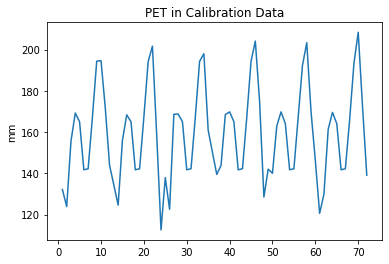

In [152]:
pet_figure = plt.figure()
pet_figure = plt.title('PET in Calibration Data')
pet_figure = plt.ylabel("mm")
pet_figure = plt.plot(calibration_df.index, calibration_df['pet'])
pet_figure = plt.show()

#### <font color=blue> Graph error between computed result for calibration period and test data </font><br>
This almost certainly shows a minor difference in the level of precision between the Python and Excel solar radiation data (constants)

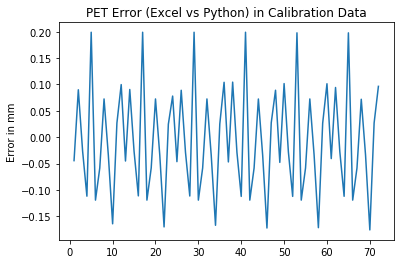

In [153]:
pet_error_figure = plt.figure()
pet_error_figure = plt.title('PET Error (Excel vs Python) in Calibration Data')
pet_error_figure = plt.ylabel("Error in mm")
pet_error_figure = plt.plot(pet_error_df.index, pet_error_df['pet_error'])
pet_error_figure = plt.show()

## <font color = purple>2. Soil moisture account </font>
 - <font color = blue> equation 11. Xt: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
 - equation 13. Wt: water avialability (Xt + water being stored already:St-1)
 - equation 14. Et: evaportranspiration
 - equation 15 and 16: Yt: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)

In [154]:
#Itehzi Tehzi Zhang constants these could be iteratively set to maximize a nash-sutcliffe score
soil_max = 100
soil_initial = 22.777650
alpha_one = 11.142492130
alpha_two = 1.582649313

In [155]:
def zhang_soilstorage(precip, pet, soil_max, soil_previous, alpha_one, alpha_two):
    #returns water stored in soil layer in mm
    #requires precip in mm, pet in mm, soil_max (maximum soil storage) in mm, soil_previous (soil storage in previous time step) in mm, alpha_one and alpha two as dimensionless calibration parameters 

    # Computation is based on the following equations in Zhang et al (2008)
    # Xt equation 11: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
    # Wt equation 13: water avialability (Xt + water being stored already:St-1)
    # Et equation 14: evaportranspiration
    # Yt equation 15 and 16: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)
  
    # compute Wt
    if precip == 0:
        #equation 11: Xt = [1 + ((Smax - Stminusone + HargreavesPET)/Precipitation) - [1 - ((Smax -Stminusone + HargreavesPET)/Precipitation)^AlphaOne]^(1/AlphaOne)] * Precipitation
        #equation 13: Wt = Xt + St-1
        Xt = 0
        Wt = soil_previous
    else:
        Xt = (1 + ((soil_max - soil_previous + pet) / precip) - (1 + ((soil_max - soil_previous + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_previous
    
    # return soilstorage
    if Wt < 0.1:
        soil_storage = 0
    else:
        Et = (1 + (pet / Wt) - (1 + (pet / Wt) ** alpha_two) ** (1 / alpha_two)) * Wt
        Yt = (1 + ((pet + soil_max) / Wt) - (1 + ((pet + soil_max) / Wt)**alpha_two)**(1 / alpha_two)) * Wt
        soil_storage = Yt - Et
    return soil_storage

#### <font color=blue> Compute Soil Storage for calibration period </font>

In [156]:
soil_previous = soil_initial
for index, row in calibration_df.iterrows():
    soil_previous = zhang_soilstorage(row['kaoma_precip'], row['pet'], soil_max, soil_previous, alpha_one, alpha_two)
    calibration_df.at[index,'soil_storage'] = soil_previous
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage
timestep,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486
2,1,2,209.1,18,29,123.883007,28.163281
3,1,3,97.6,17,29,155.684118,13.289974
4,1,4,5.6,14,29,169.238425,0.776610
5,1,5,0.0,10,28,165.057973,0.005212


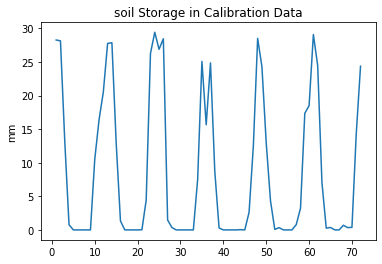

In [157]:
soil_storage_figure = plt.figure()
soil_storage_figure = plt.title('soil Storage in Calibration Data')
soil_storage_figure = plt.ylabel("mm")
soil_storage_figure = plt.plot(calibration_df.index, calibration_df['soil_storage'])
soil_storage_figure = plt.show()

#### <font color=blue> Import Soil Storage test data and compute error </font>

In [158]:
soil_storage_test_df = pd.read_csv("Inputs/Calibration/soil_storage.csv")
soil_storage_test_df.set_index('timestep', inplace=True)
soil_storage_test_df = soil_storage_test_df.rename(columns = {'soil_storage':'test_soil_storage'})
soil_storage_error_df = calibration_df.merge(soil_storage_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in soil_storage_error_df.iterrows():    
    soil_storage_error_df.at[index,'soil_storage_error'] = row['test_soil_storage'] - row['soil_storage']
soil_storage_error_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,test_soil_storage,soil_storage_error
timestep,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,28.285810,2.324405e-03
2,1,2,209.1,18,29,123.883007,28.163281,28.156767,-6.514006e-03
3,1,3,97.6,17,29,155.684118,13.289974,13.291294,1.319767e-03
4,1,4,5.6,14,29,169.238425,0.776610,0.777340,7.299788e-04
5,1,5,0.0,10,28,165.057973,0.005212,0.005212,-2.501691e-07


#### <font color=blue> Graph error between computed result for calibration period and test data </font><br>

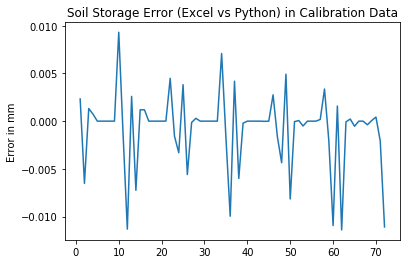

In [159]:
soil_storage_error_figure = plt.figure()
soil_storage_error_figure = plt.title('Soil Storage Error (Excel vs Python) in Calibration Data')
soil_storage_error_figure = plt.ylabel("Error in mm")
soil_storage_error_figure = plt.plot(soil_storage_error_df.index, soil_storage_error_df['soil_storage_error'])
soil_storage_error_figure = plt.show()

## <font color = purple>3. Groundwater account </font>
   - <font color = blue> equation 11. Xt: </font> rainfall available for storage and evaportranspiration (rainfall that will not runoff) 
   - <font color = blue> equation 13. Wt: </font> water avialability (Xt + water being stored already:Stminusone) 
   - <font color = blue> equation 15. and 16. Yt: </font> evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity) 
   - <font color = blue> equation 17. Rt: </font> groundwater recharge

In [160]:
#Itehzi Tehzi additional Zhang groundwater storage constants, the ground_loss_constant is not part of the Zhang system of equations
ground_initial = 150
ground_constant = 0.08
ground_loss_constant = 0.25

In [161]:
def zhang_groundstorage(precip, pet, soil_storage, soil_max, ground_previous, ground_constant, ground_loss_constant, alpha_two):
    #returns water stored in ground water layer in mm 
    #requires precip in mm, pet in mm, soil_storage in mm, ground_previous (ground water storage in previous time step) in mm, ground_constant, ground_loss_constant and alpha two as dimensionless calibration parameters 

    # Computation is based on the following equations in Zhang et al (2008)    
    #Xt equation 11: rainfall available for storage and evaportranspiration (rainfall that will not runoff)
    #Wt equation 13: water avialability (Xt + water being stored already:Stminusone)
    #Yt equation 15 and 16: evaportranspiration opportunity (potential evaportranspiration + soilwater storage capacity)
    #Rt equation 17: groundwater recharge
    
    # compute Wt
    if precip == 0:
        #equation 11: Xt = [1 + ((Smax - Stminusone + HargreavesPET)/Precipitation) - [1 - ((Smax -Stminusone + HargreavesPET)/Precipitation)^AlphaOne]^(1/AlphaOne)] * Precipitation
        #equation 13: Wt = Xt + St-1
        Xt = 0
        Wt = soil_storage
    else:
        Xt = (1 + ((soil_max - soil_storage + pet) / precip) - (1 + ((soil_max - soil_storage + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_storage
    
    # return groundwater storage (Gt)
    if Wt < 0.1:
        Rt = 0
    else:
        Yt = (1 + ((pet + soil_max) / Wt) - (1 + ((pet + soil_max) / Wt)**alpha_two)**(1 / alpha_two)) * Wt
        Rt = Wt - Yt
    return ground_previous + Rt - ground_previous * ground_constant - ground_previous * ground_loss_constant

In [162]:
ground_previous = ground_initial
for index, row in calibration_df.iterrows():
    ground_previous = zhang_groundstorage(row['kaoma_precip'], row['pet'], row['soil_storage'], soil_max, ground_previous, ground_constant, ground_loss_constant, alpha_two)
    calibration_df.at[index,'ground_storage'] = ground_previous
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage
timestep,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021
2,1,2,209.1,18,29,123.883007,28.163281,268.563295
3,1,3,97.6,17,29,155.684118,13.289974,221.110468
4,1,4,5.6,14,29,169.238425,0.776610,148.598863
5,1,5,0.0,10,28,165.057973,0.005212,99.561238


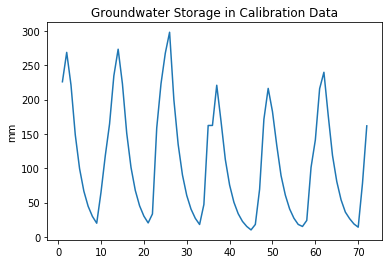

In [163]:
ground_storage_figure = plt.figure()
ground_storage_figure = plt.title('Groundwater Storage in Calibration Data')
ground_storage_figure = plt.ylabel("mm")
ground_storage_figure = plt.plot(calibration_df.index, calibration_df['ground_storage'])
ground_storage_figure = plt.show()

#### <font color=blue> Import Ground Storage test data and compute error </font>

In [164]:
ground_storage_test_df = pd.read_csv("Inputs/Calibration/ground_storage.csv")
ground_storage_test_df.set_index('timestep', inplace=True)
ground_storage_test_df = ground_storage_test_df.rename(columns = {'ground_storage':'test_ground_storage'})
ground_storage_error_df = calibration_df.merge(ground_storage_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in ground_storage_error_df.iterrows():    
    ground_storage_error_df.at[index,'ground_storage_error'] = row['test_ground_storage'] - row['ground_storage']
ground_storage_error_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,test_ground_storage,ground_storage_error
timestep,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,225.782158,-0.018863
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,268.573531,0.010236
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,221.120276,0.009808
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,148.605626,0.006763
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,99.565770,0.004531


#### <font color=blue> Graph error between computed result for calibration period and test data </font><br>

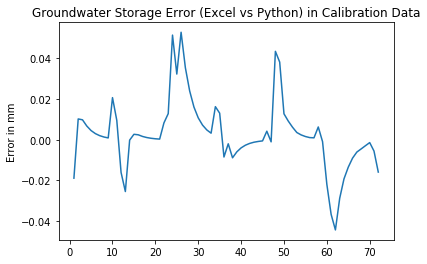

In [165]:
ground_storage_error_figure = plt.figure()
ground_storage_error_figure = plt.title('Groundwater Storage Error (Excel vs Python) in Calibration Data')
ground_storage_error_figure = plt.ylabel("Error in mm")
ground_storage_error_figure = plt.plot(ground_storage_error_df.index, ground_storage_error_df['ground_storage_error'])
ground_storage_error_figure = plt.show()

## <font color = purple>4. Evaportranspiration account </font>

In [166]:
def zhang_evaportranspiration(precip, pet, soil_storage, soil_max, alpha_one, alpha_two):
    #returns evaportanspiration in mm / month
    #requires precip in mm, pet in mm, soil_storage in mm, soil_max (maximum stoil storage) in mm, alpha_one and alpha two as dimensionless calibration parameters 

    # Computation is based on the following equations in Zhang et al (2008) 
    # compute Wt
    if precip == 0:
        Xt = 0
        Wt = soil_storage
    else:
        Xt = (1 + ((soil_max - soil_storage + pet) / precip) - (1 + ((soil_max - soil_storage + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        Wt = Xt + soil_storage
    
    # compute evaportranspiration (Et)
    if Wt < 0.1:
        return 0
    else:
        return (1 + (pet / Wt) - (1 + (pet / Wt)**alpha_two)**(1 / alpha_two)) * Wt

In [167]:
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'et'] = zhang_evaportranspiration(row['kaoma_precip'], row['pet'], row['soil_storage'], soil_max, alpha_one, alpha_two)
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et
timestep,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000


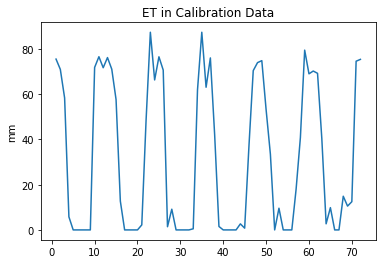

In [168]:
et_figure = plt.figure()
et_figure = plt.title('ET in Calibration Data')
et_figure = plt.ylabel("mm")
et_figure = plt.plot(calibration_df.index, calibration_df['et'])
et_figure = plt.show()

#### <font color=blue> Import ET test data and compute error </font>

In [169]:
et_test_df = pd.read_csv("Inputs/Calibration/et.csv")
et_test_df.set_index('timestep', inplace=True)
et_test_df = et_test_df.rename(columns = {'et':'test_et'})
et_error_df = calibration_df.merge(et_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in et_error_df.iterrows():    
    et_error_df.at[index,'et_error'] = row['test_et'] - row['et']
et_error_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,test_et,et_error
timestep,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031,75.390360,-0.134671
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050,71.022943,0.044892
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247,62.663906,4.322660
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782,15.581801,9.801018
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000,0.755709,0.755709


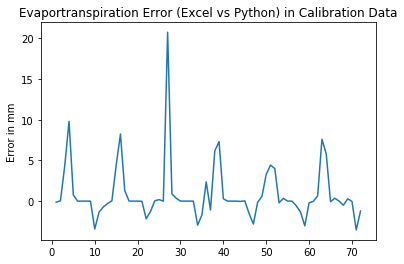

In [170]:
et_error_figure = plt.figure()
et_error_figure = plt.title('Evaportranspiration Error (Excel vs Python) in Calibration Data')
et_error_figure = plt.ylabel("Error in mm")
et_error_figure = plt.plot(et_error_df.index, et_error_df['et_error'])
et_error_figure = plt.show()

## <font color = purple>5. Stream flow volume model </font>
   - <font color = blue>baseflow</font>
   - <font color = blue>runoff</font>

In [171]:
#Itehzi Tehzi watershed size 
watershed_size = 95000 #km2

In [172]:
# Baseflow in Millions of Cubic Meters (MCM)
def zhang_baseflow(ground_previous, ground_constant, watershed_size):
    #requires 'ground_previous' (groundwater storage in previous time step) in mm, 'ground_constant' unitless calibration parameter and watershed size in km2
    #returns baseflow in MCM
    return ground_constant * ground_previous * watershed_size / 1000

In [173]:
ground_previous = ground_initial
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'baseflow'] = zhang_baseflow(ground_previous, ground_constant, watershed_size)
    ground_previous = calibration_df.at[index, 'ground_storage']
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,baseflow
timestep,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031,1140.000000
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050,1716.087759
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247,2041.081042
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782,1680.439559
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000,1129.351359


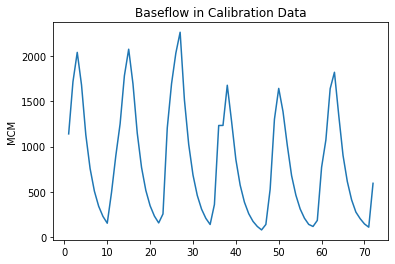

In [174]:
baseflow_figure = plt.figure()
baseflow_figure = plt.title('Baseflow in Calibration Data')
baseflow_figure = plt.ylabel("MCM")
baseflow_figure = plt.plot(calibration_df.index, calibration_df['baseflow'])
baseflow_figure = plt.show()

In [175]:
def zhang_runoff(precip, pet, soil_previous, soil_max, alpha_one, watershed_size):
    # compute direct runoff + Wt
    if precip == 0:
        return 0
    else:
        #equation 11: Xt
        Xt = (1 + ((soil_max - soil_previous + pet) / precip) - (1 + ((soil_max - soil_previous + pet) / precip)**alpha_one)**(1 / alpha_one)) * precip
        return (precip - Xt) * watershed_size / 1000

In [176]:
soil_previous = soil_initial
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'runoff'] = zhang_runoff(row['kaoma_precip'], row['pet'], soil_previous, soil_max, alpha_one, watershed_size)
    soil_previous = calibration_df.at[index, 'soil_storage']
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,baseflow,runoff
timestep,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031,1140.000000,3.516052e+03
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050,1716.087759,1.988107e+03
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247,2041.081042,1.556272e-01
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782,1680.439559,3.796963e-12
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000,1129.351359,0.000000e+00


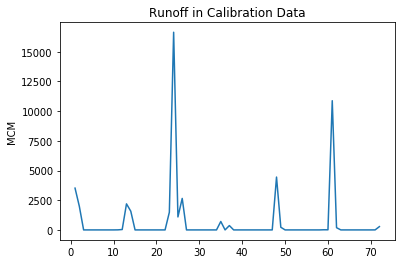

In [177]:
runoff_figure = plt.figure()
runoff_figure = plt.title('Runoff in Calibration Data')
runoff_figure = plt.ylabel("MCM")
runoff_figure = plt.plot(calibration_df.index, calibration_df['runoff'])
runoff_figure = plt.show()

In [178]:
def zhang_streamflow(runoff, baseflow):
    return runoff + baseflow

In [179]:
for index, row in calibration_df.iterrows():
    calibration_df.at[index,'streamflow'] = zhang_streamflow(row['baseflow'], row['runoff'])
calibration_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,baseflow,runoff,streamflow
timestep,,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031,1140.000000,3.516052e+03,4656.051958
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050,1716.087759,1.988107e+03,3704.195241
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247,2041.081042,1.556272e-01,2041.236669
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782,1680.439559,3.796963e-12,1680.439559
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000,1129.351359,0.000000e+00,1129.351359


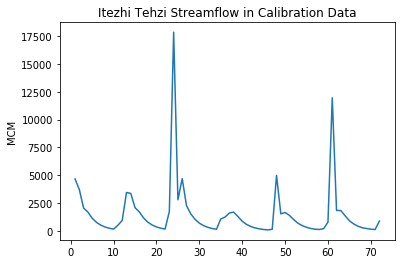

In [180]:
streamflow_figure = plt.figure()
streamflow_figure = plt.title('Itezhi Tehzi Streamflow in Calibration Data')
streamflow_figure = plt.ylabel("MCM")
streamflow_figure = plt.plot(calibration_df.index, calibration_df['streamflow'])
streamflow_figure = plt.show()

#### <font color=blue> Import Streamflow test data and compute error </font>

In [181]:
streamflow_test_df = pd.read_csv("Inputs/Calibration/streamflow.csv")
streamflow_test_df.set_index('timestep', inplace=True)
streamflow_test_df = streamflow_test_df.rename(columns = {'streamflow':'test_streamflow'})
streamflow_error_df = calibration_df.merge(streamflow_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in streamflow_error_df.iterrows():    
    streamflow_error_df.at[index,'streamflow_error'] = row['test_streamflow'] - row['streamflow']
streamflow_error_df.head()

,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,baseflow,runoff,streamflow,test_streamflow,streamflow_error
timestep,,,,,,,,,,,,,,
1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.525031,1140.000000,3.516052e+03,4656.051958,4659.452266,3.400308
2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.978050,1716.087759,1.988107e+03,3704.195241,3698.701117,-5.494124
3,1,3,97.6,17,29,155.684118,13.289974,221.110468,58.341247,2041.081042,1.556272e-01,2041.236669,2041.314598,0.077929
4,1,4,5.6,14,29,169.238425,0.776610,148.598863,5.780782,1680.439559,3.796963e-12,1680.439559,1680.514097,0.074538
5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.000000,1129.351359,0.000000e+00,1129.351359,1129.402760,0.051401


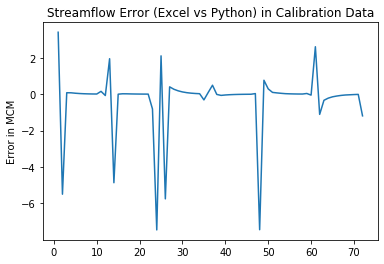

In [182]:
streamflow_error_figure = plt.figure()
streamflow_error_figure = plt.title('Streamflow Error (Excel vs Python) in Calibration Data')
streamflow_error_figure = plt.ylabel("Error in MCM")
streamflow_error_figure = plt.plot(streamflow_error_df.index, streamflow_error_df['streamflow_error'])
streamflow_error_figure = plt.show()

## <font color = purple> Generate Streamflow for Trace Data </font>

In [186]:
it_watershed_size = 95000
kg_watershed_size = 47138
soil_previous = soil_initial
ground_previous = ground_initial

in_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/traces"
out_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/streamflow"
for file_name in os.listdir(in_directory):
    df = pd.read_csv(in_directory + '/' + file_name)
    df.set_index('timestep', inplace=True, drop=True, verify_integrity=True)
    for index, row in df.iterrows():
        #compute time t values
        pet = hargreaves_pet(row['kaoma_precip'], row['min_temp'], row['max_temp'], row['month'])
        soil = zhang_soilstorage(row['kaoma_precip'], pet, soil_max, soil_previous, alpha_one, alpha_two)
        ground = zhang_groundstorage(row['kaoma_precip'], pet, soil, soil_max, ground_previous, ground_constant, ground_loss_constant, alpha_two)
        et = zhang_evaportranspiration(row['kaoma_precip'], pet, soil, soil_max, alpha_one, alpha_two)
        it_baseflow = zhang_baseflow(ground_previous, ground_constant, it_watershed_size)
        it_runoff = zhang_runoff(row['kaoma_precip'], pet, soil_previous, soil_max, alpha_one, it_watershed_size)
        it_streamflow = zhang_streamflow(it_baseflow, it_runoff)
        kg_baseflow = zhang_baseflow(ground_previous, ground_constant, kg_watershed_size)
        kg_runoff = zhang_runoff(row['kaoma_precip'], pet, soil_previous, soil_max, alpha_one, kg_watershed_size)
        kg_streamflow = zhang_streamflow(kg_baseflow, kg_runoff)
        #commit to data frame
        df.at[index,'pet'] = pet
        df.at[index,'soil_storage'] = soil
        df.at[index,'ground_storage'] = ground
        df.at[index,'et'] = et
        df.at[index,'it_baseflow'] = it_baseflow
        df.at[index,'it_runoff'] = it_runoff
        df.at[index,'it_streamflow'] = it_streamflow
        df.at[index,'kg_baseflow'] = kg_baseflow
        df.at[index,'kg_runoff'] = kg_runoff
        df.at[index,'kg_streamflow'] = kg_streamflow
        #assingment of t-1 values
        soil_previous = soil
        ground_previous = ground
    df.to_csv(out_directory + '/' + file_name)